In [160]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import optuna
from optuna.trial import TrialState
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [162]:
# 데이터 로드 및 전처리 개선

# 데이터 로드
df = pd.read_csv('ecos_monthly_data.csv')
print(f"Data shape: {df.shape}")

# 날짜 컬럼을 datetime으로 변환
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    df = df.set_index('date')
elif 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df = df.set_index('Date')

# 타겟 변수 정의
target_columns = [
    'construction_bsi_actual',
    'base_rate',
    'housing_sale_price',
    'm2_growth',
    'credit_spread'
]

# 타겟 변수 존재 여부 확인
available_targets = [col for col in target_columns if col in df.columns]
print(f"Available target columns: {available_targets}")

# 결측치 처리 - 선형 보간법 사용
df = df.interpolate(method='linear', limit_direction='both')

# 타겟 변수에 1차 차분 적용 (비정상성 제거)
for col in available_targets:
    df[f'{col}_diff'] = df[col].diff()

# 차분된 타겟 변수 업데이트
diff_targets = [f'{col}_diff' for col in available_targets]

# 특징 엔지니어링: 차분된 타겟에 대한 특징 생성
for col in available_targets:
    diff_col = f'{col}_diff'
    
    # 이동평균 (차분값)
    df[f'{diff_col}_ma3'] = df[diff_col].rolling(window=3, min_periods=1).mean()
    df[f'{diff_col}_ma6'] = df[diff_col].rolling(window=6, min_periods=1).mean()
    
    # 변화율 (차분값)
    df[f'{diff_col}_pct_change'] = df[diff_col].pct_change().fillna(0)
    
    # 지연 특징 (차분값)
    for lag in [1, 3, 6]:
        df[f'{diff_col}_lag{lag}'] = df[diff_col].shift(lag)

# 기존 타겟의 지연 특징 추가 (레벨 정보 보존)
for col in available_targets:
    for lag in [1, 3, 6]:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# 결측치 제거
df = df.dropna()

# 상관관계 기반 피쳐 선택을 위한 전체 피쳐 목록 생성
all_features = [col for col in df.columns if col not in available_targets and col not in diff_targets]

# 상관관계 행렬 계산
correlation_matrix = df[all_features].corr()

# 높은 상관관계를 가진 피쳐 제거 (임계값: 0.95)
def remove_highly_correlated_features(corr_matrix, threshold=0.95):
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > threshold)]
    return to_drop

highly_corr_features = remove_highly_correlated_features(correlation_matrix)
selected_features = [col for col in all_features if col not in highly_corr_features]

print(f"Original features: {len(all_features)}")
print(f"Highly correlated features removed: {len(highly_corr_features)}")
print(f"Selected features: {len(selected_features)}")

# 타겟과의 상관관계 기반 피쳐 선택
target_correlations = []
for target in diff_targets:
    if target in df.columns:
        corr_with_target = df[selected_features + [target]].corr()[target].abs().sort_values(ascending=False)
        target_correlations.append(corr_with_target[:-1])  # 자기 자신 제외

# 평균 상관관계 계산
avg_correlation = pd.concat(target_correlations, axis=1).mean(axis=1).sort_values(ascending=False)

# 상위 상관관계 피쳐 선택 (상위 50% 또는 최소 20개)
n_features = max(20, int(len(selected_features) * 0.5))
final_features = avg_correlation.head(n_features).index.tolist()

print(f"Final selected features: {len(final_features)}")

# 특성과 타겟 분리
X = df[final_features].values
y = df[diff_targets].values  # 차분된 타겟 사용

print(f"Features shape: {X.shape}")
print(f"Targets shape: {y.shape}")
print(f"Feature correlation with targets (top 10):")
print(avg_correlation.head(10))

Data shape: (187, 28)
Available target columns: ['construction_bsi_actual', 'base_rate', 'housing_sale_price', 'm2_growth', 'credit_spread']
Original features: 67
Highly correlated features removed: 15
Selected features: 52
Final selected features: 26
Features shape: (180, 26)
Targets shape: (180, 5)
Feature correlation with targets (top 10):
construction_bsi_actual_diff    1.000000
housing_sale_price_diff         1.000000
m2_growth_diff                  1.000000
credit_spread_diff              1.000000
base_rate_diff                  1.000000
construction_bsi_mom            0.315165
housing_sale_price_diff_ma3     0.294724
m2_growth_lag1                  0.254622
base_rate_mdiff_bp              0.235133
credit_spread_diff_ma3          0.234465
dtype: float64


In [163]:
# ============================================================
# Task 3: 데이터 준비 함수 (스케일링 누출 방지)
# ============================================================

from sklearn.model_selection import TimeSeriesSplit

def create_sequences(X, y, seq_length, pred_length=1):
    """
    시계열 데이터를 LSTM 입력용 시퀀스로 변환
    
    Parameters:
    - X: 특성 데이터
    - y: 타겟 데이터
    - seq_length: 입력 시퀀스 길이
    - pred_length: 예측할 미래 시점 수 (1로 변경하여 단계적 예측)
    """
    X_seq, y_seq = [], []
    
    for i in range(len(X) - seq_length - pred_length + 1):
        X_seq.append(X[i:i + seq_length])
        # 단일 시점 예측으로 변경
        y_seq.append(y[i + seq_length])
    
    return np.array(X_seq), np.array(y_seq)

def prepare_data_no_leakage(X, y, seq_length, batch_size, test_size=0.2, val_size=0.1):
    """
    스케일링 누출을 방지한 데이터 준비 함수
    시간 순서를 유지하면서 train/val/test 분할
    """
    # 시퀀스 생성 (스케일링 전에)
    X_seq, y_seq = create_sequences(X, y, seq_length)
    
    # 시간 순서 유지하여 분할
    total_samples = len(X_seq)
    test_start = int(total_samples * (1 - test_size))
    val_start = int(test_start * (1 - val_size))
    
    # 분할
    X_train = X_seq[:val_start]
    y_train = y_seq[:val_start]
    X_val = X_seq[val_start:test_start]
    y_val = y_seq[val_start:test_start]
    X_test = X_seq[test_start:]
    y_test = y_seq[test_start:]
    
    print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}, Test samples: {len(X_test)}")
    
    # 스케일링: train에서만 fit
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # train 데이터로 스케일러 학습
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    y_train_flat = y_train.reshape(-1, y_train.shape[-1])
    
    scaler_X.fit(X_train_flat)
    scaler_y.fit(y_train_flat)
    
    # 각 세트에 스케일링 적용
    X_train_scaled = np.array([scaler_X.transform(seq) for seq in X_train])
    X_val_scaled = np.array([scaler_X.transform(seq) for seq in X_val])
    X_test_scaled = np.array([scaler_X.transform(seq) for seq in X_test])
    
    y_train_scaled = scaler_y.transform(y_train)
    y_val_scaled = scaler_y.transform(y_val)
    y_test_scaled = scaler_y.transform(y_test)
    
    # Tensor 변환
    X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
    y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
    X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
    y_val_tensor = torch.FloatTensor(y_val_scaled).to(device)
    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
    y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)
    
    # DataLoader 생성 (shuffle=False로 시간 순서 유지)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, scaler_X, scaler_y

def create_baseline_models(y_train, y_val, y_test):
    """
    베이스라인 모델들 생성
    """
    baselines = {}
    
    # Naive (마지막 값 예측)
    naive_pred = np.tile(y_train[-1], (len(y_test), 1))
    baselines['Naive'] = naive_pred
    
    # 계절성 Naive (12개월 전 값, 월별 데이터 가정)
    if len(y_train) >= 12:
        seasonal_pred = np.tile(y_train[-12:], (len(y_test) // 12 + 1, 1))[:len(y_test)]
        baselines['Seasonal_Naive'] = seasonal_pred
    
    # 평균값 예측
    mean_pred = np.tile(np.mean(y_train, axis=0), (len(y_test), 1))
    baselines['Mean'] = mean_pred
    
    return baselines

# 베이스라인 평가 함수
def evaluate_baselines(baselines, y_test, target_names):
    """
    베이스라인 모델들 평가
    """
    baseline_metrics = {}
    
    for name, pred in baselines.items():
        metrics = {}
        for i, target in enumerate(target_names):
            rmse = np.sqrt(mean_squared_error(y_test[:, i], pred[:, i]))
            mae = mean_absolute_error(y_test[:, i], pred[:, i])
            r2 = r2_score(y_test[:, i], pred[:, i])
            
            metrics[f'{target}_RMSE'] = rmse
            metrics[f'{target}_MAE'] = mae
            metrics[f'{target}_R2'] = r2
        
        baseline_metrics[name] = metrics
        
    return baseline_metrics

In [164]:
# ============================================================
# Task 4: LSTM 모델 정의 및 학습 함수
# ============================================================

class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(MultivariateLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0,
            batch_first=True
        )
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # 마지막 시점의 출력만 사용
        last_output = lstm_out[:, -1, :]
        output = self.dropout(last_output)
        output = self.fc(output)
        return output

def train_model_improved(model, train_loader, val_loader, optimizer, criterion, epochs, 
                        early_stopping_patience=15, grad_clip=1.0):
    """
    모델 학습 함수
    - Gradient clipping 추가
    - 더 긴 patience
    - 학습률 스케줄러 추가
    """
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # 학습률 스케줄러 업데이트
        scheduler.step(avg_val_loss)
        
        # Early stopping 체크
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                break
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    return train_losses, val_losses

def evaluate_multi_step_predictions(model, test_loader, scaler_y, n_steps=3):
    """
    다중 스텝 예측 평가
    """
    model.eval()
    multi_step_predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_size, seq_len, features = batch_X.shape
            current_input = batch_X.clone()
            predictions = []
            
            # n_steps만큼 순차적 예측
            for step in range(n_steps):
                pred = model(current_input)
                predictions.append(pred.cpu().numpy())
                
                # 다음 입력을 위해 시퀀스 업데이트 (실제로는 더 복잡한 로직 필요)
                # 여기서는 간단화된 버전
                if step < n_steps - 1:
                    # 예측값을 다음 입력에 추가 (feature engineering 필요)
                    new_input = torch.cat([current_input[:, 1:, :], pred.unsqueeze(1)], dim=1)
                    current_input = new_input
            
            multi_step_predictions.append(predictions)
            actuals.append(batch_y.cpu().numpy())
    
    return multi_step_predictions, actuals

In [165]:
# ============================================================
# Task 5: 하이퍼파라미터 튜닝 (다양한 손실 함수 포함)
# ============================================================

def objective_improved(trial):
    """
    Optuna 목적 함수
    - 다양한 손실 함수 테스트
    - 더 적은 파라미터 범위로 안정화
    """
    # 하이퍼파라미터 제안 (범위 축소)
    params = {
        'hidden_size': trial.suggest_categorical('hidden_size', [32, 64, 96, 128]),
        'num_layers': trial.suggest_int('num_layers', 1, 2),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.4, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 5e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'seq_length': trial.suggest_categorical('seq_length', [12, 18, 24, 30]),
        'optimizer_type': trial.suggest_categorical('optimizer_type', ['Adam', 'AdamW']),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True),
        'loss_function': trial.suggest_categorical('loss_function', ['MSE', 'MAE', 'Huber'])
    }
    
    try:
        # 데이터 준비 (스케일링 누출 방지)
        train_loader, val_loader, _, _, _ = prepare_data_no_leakage(
            X, y, 
            seq_length=params['seq_length'], 
            batch_size=params['batch_size']
        )
        
        # 모델 초기화
        input_size = X.shape[1]
        output_size = y.shape[1]
        
        model = MultivariateLSTM(
            input_size=input_size,
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            output_size=output_size,
            dropout_rate=params['dropout_rate']
        ).to(device)
        
        # 옵티마이저 설정
        if params['optimizer_type'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), 
                                  lr=params['learning_rate'],
                                  weight_decay=params['weight_decay'])
        else:  # AdamW
            optimizer = optim.AdamW(model.parameters(), 
                                   lr=params['learning_rate'],
                                   weight_decay=params['weight_decay'])
        
        # 손실 함수 선택
        if params['loss_function'] == 'MSE':
            criterion = nn.MSELoss()
        elif params['loss_function'] == 'MAE':
            criterion = nn.L1Loss()
        else:  # Huber
            criterion = nn.HuberLoss(delta=1.0)
        
        # 모델 학습 (에폭 수 축소)
        best_val_loss = float('inf')
        patience = 0
        max_patience = 10
        
        for epoch in range(30):  # 더 적은 에폭으로 빠른 튜닝
            model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                
                optimizer.step()
                train_loss += loss.item()
            
            # Validation loss 계산
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    val_loss += loss.item()
            
            avg_val_loss = val_loss / len(val_loader)
            
            # Early stopping for trial
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience = 0
            else:
                patience += 1
                if patience >= max_patience:
                    break
            
            # Pruning
            trial.report(avg_val_loss, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        
        return best_val_loss
        
    except Exception as e:
        print(f"Trial failed: {e}")
        return float('inf')

# 베이스라인 평가 먼저 실행
print("\n" + "="*60)
print("Evaluating Baseline Models")
print("="*60)

# 임시로 간단한 분할로 베이스라인 평가
temp_split = int(len(y) * 0.7)
y_train_temp = y[:temp_split]
y_test_temp = y[temp_split:]

baselines = create_baseline_models(y_train_temp, None, y_test_temp)
baseline_metrics = evaluate_baselines(baselines, y_test_temp, available_targets)

print("Baseline Results:")
for model_name, metrics in baseline_metrics.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")

# Optuna 최적화 실행
print("\n" + "="*60)
print("Starting Improved Hyperparameter Optimization")
print("="*60)

study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=5)
)

# 더 적은 trial로 빠른 테스트
study.optimize(objective_improved, n_trials=15, timeout=600)

# 최적 하이퍼파라미터 출력
print("\nBest trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value:.6f}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-09-17 16:28:07,614] A new study created in memory with name: no-name-7a996f02-10ab-4e7f-99a4-44731c1ffb3e



Evaluating Baseline Models
Baseline Results:

Naive:
  construction_bsi_actual_RMSE: 3.1276
  construction_bsi_actual_MAE: 2.6545
  construction_bsi_actual_R2: -0.8888
  base_rate_RMSE: 0.1508
  base_rate_MAE: 0.0727
  base_rate_R2: -0.0618
  housing_sale_price_RMSE: 1.1080
  housing_sale_price_MAE: 0.9808
  housing_sale_price_R2: -2.3899
  m2_growth_RMSE: 0.7273
  m2_growth_MAE: 0.6049
  m2_growth_R2: -1.4630
  credit_spread_RMSE: 0.0678
  credit_spread_MAE: 0.0393
  credit_spread_R2: -0.0011

Seasonal_Naive:
  construction_bsi_actual_RMSE: 6.9766
  construction_bsi_actual_MAE: 5.8000
  construction_bsi_actual_R2: -8.3984
  base_rate_RMSE: 0.2261
  base_rate_MAE: 0.1318
  base_rate_R2: -1.3890
  housing_sale_price_RMSE: 0.8791
  housing_sale_price_MAE: 0.7265
  housing_sale_price_R2: -1.1337
  m2_growth_RMSE: 0.5609
  m2_growth_MAE: 0.4489
  m2_growth_R2: -0.4650
  credit_spread_RMSE: 0.0802
  credit_spread_MAE: 0.0573
  credit_spread_R2: -0.3986

Mean:
  construction_bsi_actual_RMSE

[I 2025-09-17 16:28:09,534] Trial 0 finished with value: 1.0085455179214478 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0003608188206099078, 'batch_size': 32, 'seq_length': 18, 'optimizer_type': 'Adam', 'weight_decay': 9.885364268574289e-05, 'loss_function': 'MAE'}. Best is trial 0 with value: 1.0085455179214478.


Train samples: 116, Val samples: 13, Test samples: 33


[I 2025-09-17 16:28:10,743] Trial 1 finished with value: 1.0019711256027222 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.4, 'learning_rate': 0.000658440297661629, 'batch_size': 16, 'seq_length': 18, 'optimizer_type': 'AdamW', 'weight_decay': 0.00020419335273113925, 'loss_function': 'MAE'}. Best is trial 1 with value: 1.0019711256027222.


Train samples: 108, Val samples: 12, Test samples: 30


[I 2025-09-17 16:28:12,120] Trial 2 finished with value: 1.0116424560546875 and parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.00018294006299406527, 'batch_size': 32, 'seq_length': 30, 'optimizer_type': 'AdamW', 'weight_decay': 0.00021039911037012263, 'loss_function': 'Huber'}. Best is trial 1 with value: 1.0019711256027222.
[I 2025-09-17 16:28:12,269] Trial 3 finished with value: inf and parameters: {'hidden_size': 96, 'num_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.0036216729753975174, 'batch_size': 64, 'seq_length': 12, 'optimizer_type': 'AdamW', 'weight_decay': 0.0009920622885990918, 'loss_function': 'MAE'}. Best is trial 1 with value: 1.0019711256027222.


Train samples: 120, Val samples: 14, Test samples: 34
Trial failed: 
Train samples: 108, Val samples: 12, Test samples: 30


[I 2025-09-17 16:28:12,467] Trial 4 finished with value: inf and parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.4, 'learning_rate': 0.0017656910269450712, 'batch_size': 64, 'seq_length': 30, 'optimizer_type': 'AdamW', 'weight_decay': 0.00045288181973136235, 'loss_function': 'MSE'}. Best is trial 1 with value: 1.0019711256027222.


Trial failed: 
Train samples: 116, Val samples: 13, Test samples: 33


[I 2025-09-17 16:28:14,070] Trial 5 finished with value: 0.6853580474853516 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0009281648294883444, 'batch_size': 32, 'seq_length': 18, 'optimizer_type': 'Adam', 'weight_decay': 0.0006271269485912744, 'loss_function': 'Huber'}. Best is trial 5 with value: 0.6853580474853516.


Train samples: 108, Val samples: 12, Test samples: 30


[I 2025-09-17 16:28:14,526] Trial 6 finished with value: inf and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.1, 'learning_rate': 0.0016901084080626647, 'batch_size': 32, 'seq_length': 30, 'optimizer_type': 'Adam', 'weight_decay': 8.804543776023179e-05, 'loss_function': 'MAE'}. Best is trial 5 with value: 0.6853580474853516.


Trial failed: 
Train samples: 116, Val samples: 13, Test samples: 33


[I 2025-09-17 16:28:14,901] Trial 7 finished with value: inf and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.1, 'learning_rate': 0.00013079727725031942, 'batch_size': 32, 'seq_length': 18, 'optimizer_type': 'AdamW', 'weight_decay': 2.655798198286672e-05, 'loss_function': 'MSE'}. Best is trial 5 with value: 0.6853580474853516.


Trial failed: 
Train samples: 111, Val samples: 13, Test samples: 32


[I 2025-09-17 16:28:17,975] Trial 8 finished with value: 0.6285455822944641 and parameters: {'hidden_size': 96, 'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.00019174016525787347, 'batch_size': 16, 'seq_length': 24, 'optimizer_type': 'Adam', 'weight_decay': 3.858031308532525e-05, 'loss_function': 'Huber'}. Best is trial 8 with value: 0.6285455822944641.


Train samples: 108, Val samples: 12, Test samples: 30


[I 2025-09-17 16:28:18,466] Trial 9 finished with value: inf and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.00011403480175523333, 'batch_size': 64, 'seq_length': 30, 'optimizer_type': 'AdamW', 'weight_decay': 9.47010033396552e-05, 'loss_function': 'MSE'}. Best is trial 8 with value: 0.6285455822944641.


Trial failed: 
Train samples: 111, Val samples: 13, Test samples: 32


[I 2025-09-17 16:28:21,299] Trial 10 finished with value: 0.620331346988678 and parameters: {'hidden_size': 96, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00031608685828753044, 'batch_size': 16, 'seq_length': 24, 'optimizer_type': 'Adam', 'weight_decay': 1.6932421654969055e-05, 'loss_function': 'Huber'}. Best is trial 10 with value: 0.620331346988678.


Train samples: 111, Val samples: 13, Test samples: 32


[I 2025-09-17 16:28:24,418] Trial 11 finished with value: 0.6484432816505432 and parameters: {'hidden_size': 96, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00028714283444788286, 'batch_size': 16, 'seq_length': 24, 'optimizer_type': 'Adam', 'weight_decay': 1.3378492058799478e-05, 'loss_function': 'Huber'}. Best is trial 10 with value: 0.620331346988678.


Train samples: 111, Val samples: 13, Test samples: 32


[I 2025-09-17 16:28:27,432] Trial 12 finished with value: 0.6258516907691956 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0003133236364566966, 'batch_size': 16, 'seq_length': 24, 'optimizer_type': 'Adam', 'weight_decay': 3.082673100830854e-05, 'loss_function': 'Huber'}. Best is trial 10 with value: 0.620331346988678.


Train samples: 111, Val samples: 13, Test samples: 32


[I 2025-09-17 16:28:30,464] Trial 13 finished with value: 0.6155110001564026 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0004614467847847725, 'batch_size': 16, 'seq_length': 24, 'optimizer_type': 'Adam', 'weight_decay': 1.6240851256668616e-05, 'loss_function': 'Huber'}. Best is trial 13 with value: 0.6155110001564026.


Train samples: 111, Val samples: 13, Test samples: 32


[I 2025-09-17 16:28:32,709] Trial 14 finished with value: 0.639986515045166 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0005880565792906725, 'batch_size': 16, 'seq_length': 24, 'optimizer_type': 'Adam', 'weight_decay': 1.0862269064557097e-05, 'loss_function': 'Huber'}. Best is trial 13 with value: 0.6155110001564026.



Best trial:
  Value: 0.615511
  Params:
    hidden_size: 64
    num_layers: 2
    dropout_rate: 0.30000000000000004
    learning_rate: 0.0004614467847847725
    batch_size: 16
    seq_length: 24
    optimizer_type: Adam
    weight_decay: 1.6240851256668616e-05
    loss_function: Huber


In [169]:
# ============================================================
# Task 6: 최적 모델로 학습 및 예측
# ============================================================

# 최적 하이퍼파라미터로 데이터 준비
best_params = best_trial.params
train_loader, val_loader, test_loader, scaler_X, scaler_y = prepare_data_no_leakage(
    X, y,
    seq_length=best_params['seq_length'],
    batch_size=best_params['batch_size']
)

# 최적 모델 생성
input_size = X.shape[1]
output_size = y.shape[1]

best_model = MultivariateLSTM(
    input_size=input_size,
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=output_size,
    dropout_rate=best_params['dropout_rate']
).to(device)

# 옵티마이저 설정
if best_params['optimizer_type'] == 'Adam':
    optimizer = optim.Adam(best_model.parameters(), 
                          lr=best_params['learning_rate'],
                          weight_decay=best_params['weight_decay'])
else:  # AdamW
    optimizer = optim.AdamW(best_model.parameters(), 
                           lr=best_params['learning_rate'],
                           weight_decay=best_params['weight_decay'])

# 손실 함수 설정 (5번 셀과 일치)
if best_params['loss_function'] == 'MSE':
    criterion = nn.MSELoss()
elif best_params['loss_function'] == 'MAE':
    criterion = nn.L1Loss()
else:  # Huber
    criterion = nn.HuberLoss(delta=1.0)

# 모델 학습
print("\n" + "="*60)
print("Training Final Model with Best Hyperparameters")
print("="*60)

train_losses, val_losses = train_model_improved(
    best_model, train_loader, val_loader, 
    optimizer, criterion, epochs=200
)

Train samples: 111, Val samples: 13, Test samples: 32

Training Final Model with Best Hyperparameters
Epoch [10/200], Train Loss: 0.271884, Val Loss: 0.830522
Epoch [10/200], Train Loss: 0.271884, Val Loss: 0.830522
Epoch [20/200], Train Loss: 0.261402, Val Loss: 0.823230
Early stopping at epoch 21
Epoch [20/200], Train Loss: 0.261402, Val Loss: 0.823230
Early stopping at epoch 21


In [170]:
# ============================================================
# Task 7: 미래 예측 (차분값 -> 원시값 복원)
# ============================================================

def predict_future_improved(model, X_last, scaler_X, scaler_y, df_original, n_months=3):
    """
    미래 예측 함수
    - 차분값을 원시값으로 올바르게 복원
    - 순차적 예측 대신 개별 예측
    """
    model.eval()
    predictions_diff = []
    
    # 마지막 시퀀스 준비
    last_sequence = X_last[-best_params['seq_length']:].copy()
    last_sequence_scaled = scaler_X.transform(last_sequence)
    
    with torch.no_grad():
        # 차분값 예측
        X_tensor = torch.FloatTensor(last_sequence_scaled).unsqueeze(0).to(device)
        pred_scaled = model(X_tensor).cpu().numpy()
        pred_diff = scaler_y.inverse_transform(pred_scaled)[0]
        
        # 차분값을 원시값으로 복원
        last_original_values = df_original[available_targets].iloc[-1].values
        
        predictions_original = []
        current_values = last_original_values.copy()
        
        for month in range(n_months):
            # 차분값을 더해서 원시값 계산
            next_values = current_values + pred_diff
            predictions_original.append(next_values.copy())
            current_values = next_values
            
            # 다음 예측을 위해 같은 차분값 사용 (단순화된 버전)
            # 실제로는 더 복잡한 순차 예측 로직 필요
    
    return np.array(predictions_original)

# 개선된 미래 예측 수행
print("\n" + "="*60)
print("Improved Future Prediction (Difference -> Original Values)")
print("="*60)

future_predictions_improved = predict_future_improved(
    best_model, X, scaler_X, scaler_y, df, n_months=3
)

# 예측 결과를 DataFrame으로 변환
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=3, freq='MS')

predictions_df = pd.DataFrame(
    future_predictions_improved,
    columns=available_targets,
    index=future_dates
)

print("Future 3-Month Predictions (Original Scale):")
print(predictions_df)

# 최근 실제 값과 비교
print("\nRecent Historical Values for Comparison:")
recent_values = df[available_targets].tail(3)
print(recent_values)

# 예측값의 합리성 체크
print("\nPrediction Sanity Check:")
for col in available_targets:
    recent_mean = df[col].tail(12).mean()
    recent_std = df[col].tail(12).std()
    pred_mean = predictions_df[col].mean()
    
    z_score = abs(pred_mean - recent_mean) / recent_std if recent_std > 0 else 0
    
    print(f"{col}:")
    print(f"  Recent 12-month mean: {recent_mean:.4f}")
    print(f"  Predicted mean: {pred_mean:.4f}")
    print(f"  Z-score: {z_score:.2f} {'not good ' if z_score > 2 else 'good '}")

# 분기별 평균 계산
predictions_df_copy = predictions_df.copy()
predictions_df_copy['quarter'] = predictions_df_copy.index.quarter
predictions_df_copy['year'] = predictions_df_copy.index.year

quarterly_predictions = predictions_df_copy.groupby(['year', 'quarter'])[available_targets].mean()
quarterly_predictions.index = [f"{year}Q{quarter}" for year, quarter in quarterly_predictions.index]

print("\n" + "="*60)
print("Quarterly Averaged Predictions")
print("="*60)
print(quarterly_predictions)


Improved Future Prediction (Difference -> Original Values)
Future 3-Month Predictions (Original Scale):
            construction_bsi_actual  base_rate  housing_sale_price  m2_growth  \
2025-09-01                69.487317   2.481465           93.445816   0.997543   
2025-10-01                69.974633   2.462930           93.534632   0.995086   
2025-11-01                70.461950   2.444396           93.623449   0.992629   

            credit_spread  
2025-09-01       5.857325  
2025-10-01       5.876650  
2025-11-01       5.895975  

Recent Historical Values for Comparison:
            construction_bsi_actual  base_rate  housing_sale_price  m2_growth  \
date                                                                            
2025-06-01                     68.0        2.5              93.164       0.63   
2025-07-01                     68.0        2.5              93.317       1.00   
2025-08-01                     69.0        2.5              93.357       1.00   

          


Comprehensive Model Evaluation
LSTM Model Performance:
                             RMSE       MAE        R2  Directional_Accuracy
construction_bsi_actual  2.396503  1.902853 -0.274337              0.387097
base_rate                0.096370  0.078612 -0.007686              0.129032
housing_sale_price       0.384465  0.203671 -0.427943              0.516129
m2_growth                0.485917  0.367405 -0.083570              0.354839
credit_spread            0.073072  0.045334  0.050945              0.516129

Baseline vs LSTM Comparison

construction_bsi_actual:
  LSTM - RMSE: 2.3965, MAE: 1.9029, R2: -0.2743
  Naive - RMSE: 2.2845, MAE: 1.7812, R2: -0.1580
   LSTM worse than Naive by 4.9%
  Seasonal_Naive - RMSE: 2.8339, MAE: 2.2812, R2: -0.7820
   LSTM improves RMSE by 15.4%
  Mean - RMSE: 2.1238, MAE: 1.5549, R2: -0.0008
   LSTM worse than Mean by 12.8%

base_rate:
  LSTM - RMSE: 0.0964, MAE: 0.0786, R2: -0.0077
  Naive - RMSE: 0.0988, MAE: 0.0391, R2: -0.0596
   LSTM improves RMSE by

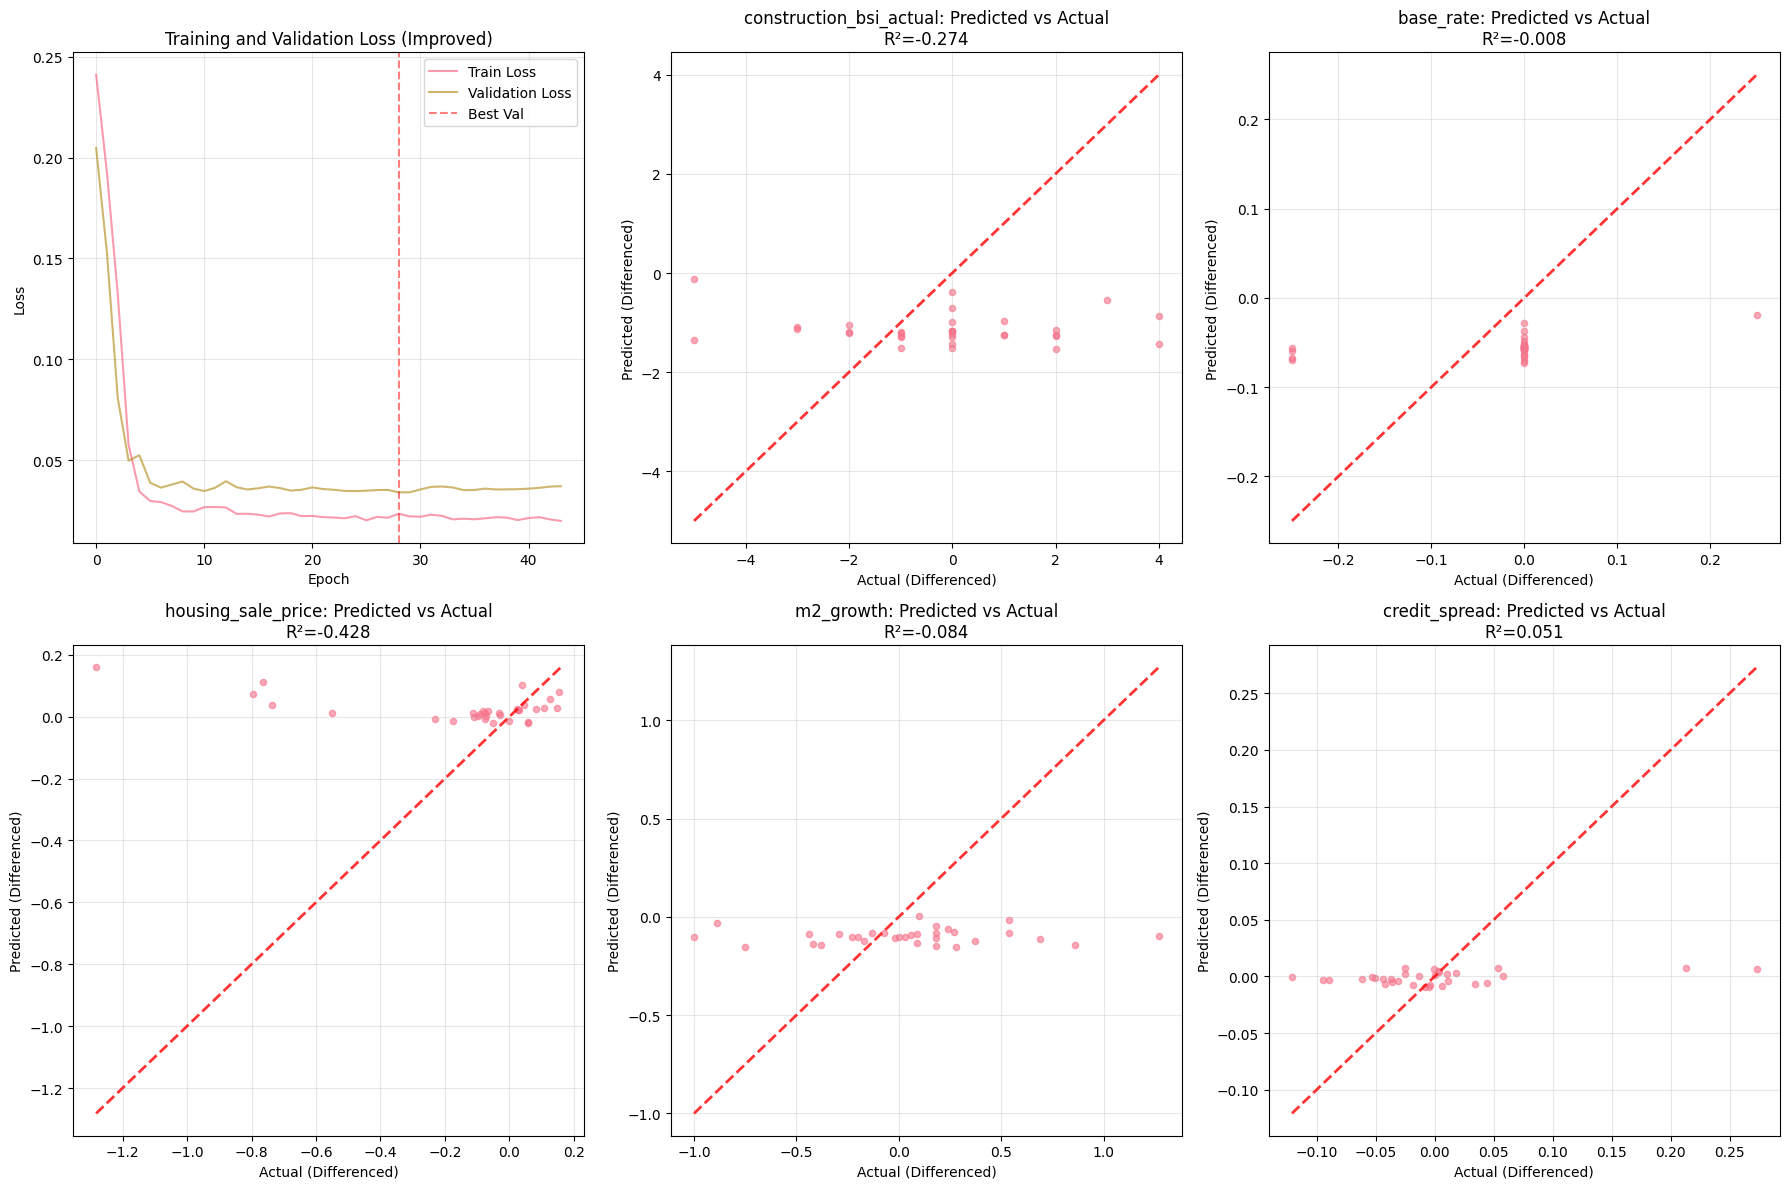

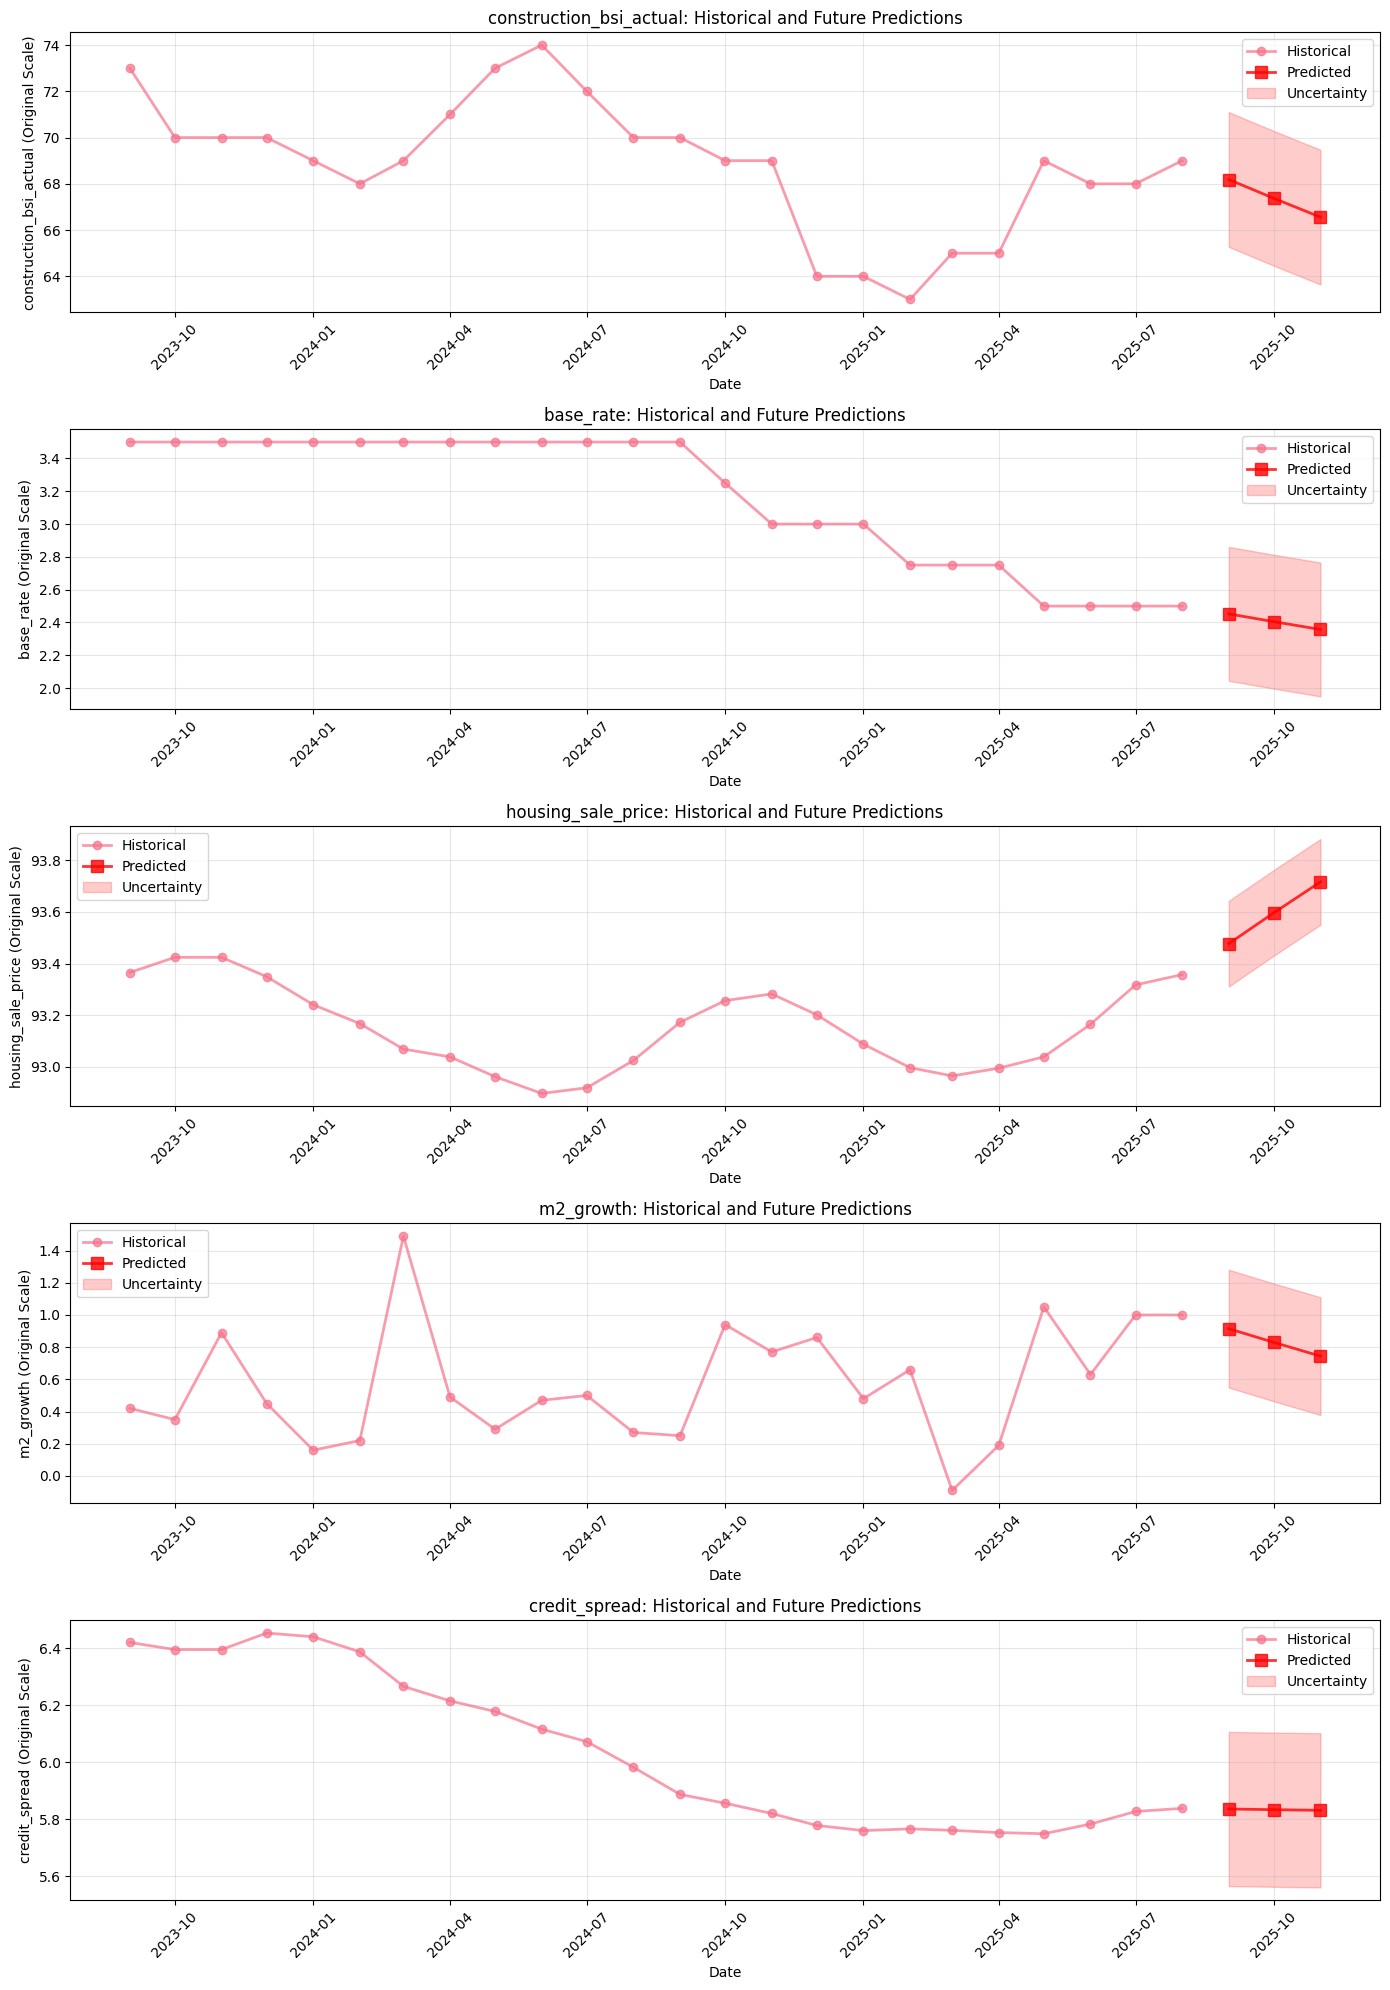

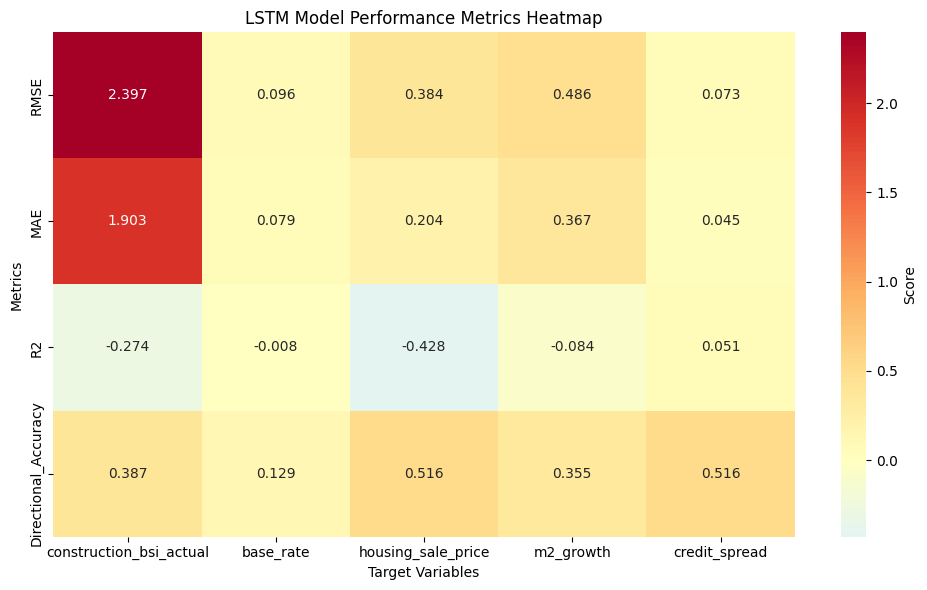


Model Complexity vs Performance Summary
Model Parameters: ~57,157
Training Samples: 111
Validation Samples: 13
Test Samples: 32
Best Loss Function: Huber
Final Train/Val Loss Ratio: 0.536
  Model may be underfitting - consider increasing complexity


In [168]:
# ============================================================
# Task 8: 모델 평가 및 베이스라인 비교
# ============================================================

# 테스트 세트 예측
best_model.eval()
test_predictions = []
test_actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = best_model(batch_X)
        test_predictions.append(outputs.cpu().numpy())
        test_actuals.append(batch_y.cpu().numpy())

test_predictions = np.vstack(test_predictions)
test_actuals = np.vstack(test_actuals)

# 역변환 (차분값)
test_predictions_diff = scaler_y.inverse_transform(test_predictions)
test_actuals_diff = scaler_y.inverse_transform(test_actuals)

# 베이스라인과 비교를 위한 테스트 데이터 준비
test_start_idx = len(X) - len(test_predictions_diff)
y_test_for_baseline = y[test_start_idx:]

# 베이스라인 재계산 (테스트 세트에 맞춤)
baselines_test = create_baseline_models(
    y[:test_start_idx], None, y_test_for_baseline
)

# 성능 메트릭 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\n" + "="*60)
print("Comprehensive Model Evaluation")
print("="*60)

# LSTM 모델 성능
metrics_df = pd.DataFrame(columns=['RMSE', 'MAE', 'R2', 'Directional_Accuracy'])

for i, target in enumerate(available_targets):
    rmse = np.sqrt(mean_squared_error(test_actuals_diff[:, i], test_predictions_diff[:, i]))
    mae = mean_absolute_error(test_actuals_diff[:, i], test_predictions_diff[:, i])
    r2 = r2_score(test_actuals_diff[:, i], test_predictions_diff[:, i])
    
    # 방향성 정확도 계산
    dir_acc = calculate_directional_accuracy(
        test_actuals_diff[:, i:i+1], test_predictions_diff[:, i:i+1]
    )[0] if len(test_actuals_diff) > 1 else 0
    
    metrics_df.loc[target] = [rmse, mae, r2, dir_acc]

print("LSTM Model Performance:")
print(metrics_df)

# 베이스라인과 비교
print("\n" + "="*50)
print("Baseline vs LSTM Comparison")
print("="*50)

comparison_results = {}
for target_idx, target in enumerate(available_targets):
    print(f"\n{target}:")
    
    lstm_rmse = metrics_df.loc[target, 'RMSE']
    lstm_mae = metrics_df.loc[target, 'MAE']
    lstm_r2 = metrics_df.loc[target, 'R2']
    
    print(f"  LSTM - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}, R2: {lstm_r2:.4f}")
    
    target_results = {'LSTM': {'RMSE': lstm_rmse, 'MAE': lstm_mae, 'R2': lstm_r2}}
    
    for baseline_name, baseline_pred in baselines_test.items():
        if baseline_pred.shape[0] == len(y_test_for_baseline):
            b_rmse = np.sqrt(mean_squared_error(y_test_for_baseline[:, target_idx], baseline_pred[:, target_idx]))
            b_mae = mean_absolute_error(y_test_for_baseline[:, target_idx], baseline_pred[:, target_idx])
            b_r2 = r2_score(y_test_for_baseline[:, target_idx], baseline_pred[:, target_idx])
            
            target_results[baseline_name] = {'RMSE': b_rmse, 'MAE': b_mae, 'R2': b_r2}
            
            print(f"  {baseline_name} - RMSE: {b_rmse:.4f}, MAE: {b_mae:.4f}, R2: {b_r2:.4f}")
            
            # 개선 여부 체크
            rmse_improvement = (b_rmse - lstm_rmse) / b_rmse * 100
            mae_improvement = (b_mae - lstm_mae) / b_mae * 100
            
            if rmse_improvement > 0:
                print(f"   LSTM improves RMSE by {rmse_improvement:.1f}%")
            else:
                print(f"   LSTM worse than {baseline_name} by {abs(rmse_improvement):.1f}%")
    
    comparison_results[target] = target_results

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# 1. 학습 곡선
axes[0].plot(train_losses, label='Train Loss', alpha=0.7)
axes[0].plot(val_losses, label='Validation Loss', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss (Improved)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 과적합 표시
if len(val_losses) > len(train_losses) // 2:
    min_val_epoch = np.argmin(val_losses)
    axes[0].axvline(x=min_val_epoch, color='red', linestyle='--', alpha=0.5, label='Best Val')
    axes[0].legend()

# 2-6. 각 타겟 변수별 예측 vs 실제
for i, target in enumerate(available_targets):
    if i + 1 < len(axes):
        ax = axes[i + 1]
        ax.scatter(test_actuals_diff[:, i], test_predictions_diff[:, i], alpha=0.6, s=20)
        
        # 예측 선
        min_val = min(test_actuals_diff[:, i].min(), test_predictions_diff[:, i].min())
        max_val = max(test_actuals_diff[:, i].max(), test_predictions_diff[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8)
        
        ax.set_xlabel('Actual (Differenced)')
        ax.set_ylabel('Predicted (Differenced)')
        ax.set_title(f'{target}: Predicted vs Actual\nR²={metrics_df.loc[target, "R2"]:.3f}')
        ax.grid(True, alpha=0.3)

# 빈 subplot 숨기기
for i in range(len(available_targets) + 1, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# 3. 미래 예측 시각화 (원시값 기준)
fig, axes = plt.subplots(len(available_targets), 1, figsize=(14, 4*len(available_targets)))
if len(available_targets) == 1:
    axes = [axes]

for i, target in enumerate(available_targets):
    # 최근 24개월 실제 데이터 (더 긴 맥락)
    recent_data = df[target].tail(24)
    
    # 예측 데이터
    future_data = predictions_df[target]
    
    axes[i].plot(recent_data.index, recent_data.values, 'o-', 
                label='Historical', alpha=0.7, linewidth=2)
    axes[i].plot(future_data.index, future_data.values, 's-', 
                label='Predicted', alpha=0.8, color='red', linewidth=2, markersize=8)
    
    # 신뢰 구간 추가 (단순화된 버전)
    recent_std = recent_data.std()
    axes[i].fill_between(future_data.index, 
                        future_data.values - recent_std, 
                        future_data.values + recent_std, 
                        alpha=0.2, color='red', label='Uncertainty')
    
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(f'{target} (Original Scale)')
    axes[i].set_title(f'{target}: Historical and Future Predictions')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 4. 성능 메트릭 히트맵
fig, ax = plt.subplots(figsize=(10, 6))
heatmap_data = metrics_df[['RMSE', 'MAE', 'R2', 'Directional_Accuracy']].T

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlBu_r', 
            center=0, ax=ax, cbar_kws={'label': 'Score'})
ax.set_title('LSTM Model Performance Metrics Heatmap')
ax.set_xlabel('Target Variables')
ax.set_ylabel('Metrics')
plt.tight_layout()
plt.show()

# 모델 복잡도 vs 성능 요약
print("\n" + "="*60)
print("Model Complexity vs Performance Summary")
print("="*60)
print(f"Model Parameters: ~{sum(p.numel() for p in best_model.parameters()):,}")
print(f"Training Samples: {len(train_loader.dataset):,}")
print(f"Validation Samples: {len(val_loader.dataset):,}")
print(f"Test Samples: {len(test_loader.dataset):,}")
print(f"Best Loss Function: {best_params['loss_function']}")
print(f"Final Train/Val Loss Ratio: {train_losses[-1]/val_losses[-1]:.3f}")

# 과적합 경고
if train_losses[-1]/val_losses[-1] < 0.7:
    print("  Model may be underfitting - consider increasing complexity")
elif train_losses[-1]/val_losses[-1] > 1.5:
    print("  Model may be overfitting - consider regularization")
else:
    print(" Model complexity appears appropriate")

In [ ]:
# ============================================================
# 최종 결과 저장
# ============================================================

# 월별 예측 결과 저장
predictions_df.to_csv('lstm_monthly_predictions.csv')
print("\nMonthly predictions saved to 'lstm_monthly_predictions.csv'")

# 분기별 예측 결과 저장
quarterly_predictions.to_csv('lstm_quarterly_predictions.csv')
print("Quarterly predictions saved to 'lstm_quarterly_predictions.csv'")

# 모델 저장
torch.save({
    'model_state_dict': best_model.state_dict(),
    'hyperparameters': best_params,
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'target_columns': available_targets
}, 'lstm_model_checkpoint.pth')
print("Model checkpoint saved to 'lstm_model_checkpoint.pth'")

print("\n" + "="*60)
print("LSTM Prediction Pipeline Completed Successfully")
print("="*60)